In [164]:
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import entropy

# === Step 1: Load Data ===
df = pd.read_csv("/Users/moo/Desktop/MSc Business Analytics/BEMM466 Business project/Interdisciplinary Finalised/arxiv_ai_with_original_and_reduced_topics_labeled.csv")
top_50_df = pd.read_csv("/Users/moo/Desktop/MSc Business Analytics/BEMM466 Business project/Interdisciplinary Finalised/Top 50 category codes.csv")
top_50_set = set(top_50_df["code"])

# === Step 2: Parse and Normalize Categories ===
df['parsed_categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

def normalize_categories(category_list):
    normalized = []
    for item in category_list:
        item_cleaned = re.sub(r'\s*\(.*?\)', '', item)  # Remove anything in parentheses
        split_parts = re.split(r'[;,]', item_cleaned)   # Split by , or ;
        normalized.extend([p.strip() for p in split_parts if p.strip()])
    return normalized

df['normalized_categories'] = df['parsed_categories'].apply(normalize_categories)

# === Step 3: Document Coverage (Has any Top 50 category?) ===
def has_top_50(categories):
    return any(cat in top_50_set for cat in categories)

df['has_top_50'] = df['normalized_categories'].apply(has_top_50)
doc_coverage_pct = df['has_top_50'].mean() * 100

# === Step 4: Category Mention Coverage ===
all_mentions = df['normalized_categories'].explode()
total_mentions = len(all_mentions)
top_50_mentions = all_mentions[all_mentions.isin(top_50_set)]
mention_coverage_pct = (len(top_50_mentions) / total_mentions) * 100

# === Step 5: Print Results ===
print(f"Document Coverage: {doc_coverage_pct:.2f}%")
print(f"Category Mention Coverage: {mention_coverage_pct:.2f}%")

Document Coverage: 100.00%
Category Mention Coverage: 90.24%


In [166]:
# === Step 5: Build Topic × Category Co-occurrence Matrix ===
topic_category_counts = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    topic = row["reduced_topic"]
    for cat in row["normalized_categories"]:
        if cat in top_50_set:
            topic_category_counts[topic][cat] += 1

matrix_df = pd.DataFrame(topic_category_counts).T.fillna(0).astype(int)

# Reorder columns to match Top 50 order
ordered_cols = [code for code in top_50_df["code"] if code in matrix_df.columns]
matrix_df = matrix_df[ordered_cols]

In [168]:
# === Step 6: Normalize Matrix (Row-wise Proportions) ===
normalized_matrix_df = matrix_df.div(matrix_df.sum(axis=1), axis=0)

In [170]:
# === Step 7: Interdisciplinarity Score (Entropy) ===
normalized_matrix_df["interdisciplinarity_score"] = normalized_matrix_df.apply(entropy, axis=1)

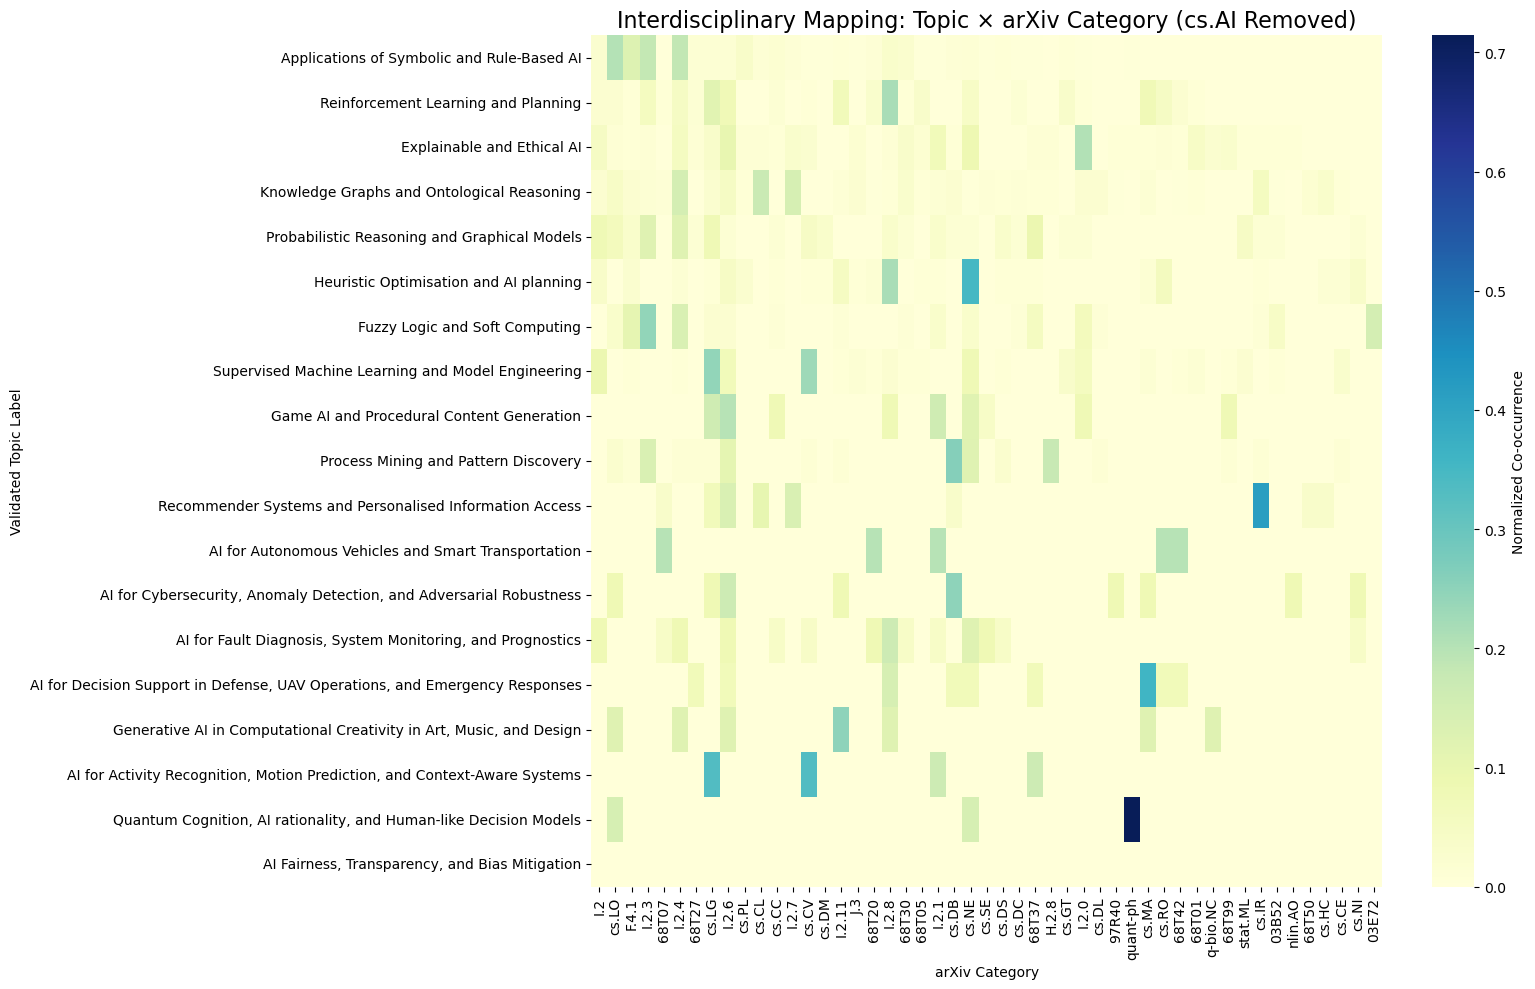

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Step 1: Filter dataset
filtered_df = df[(df["reduced_topic"] != -1) & (df["validated_topic"].notna())]

# Step 2: Get all topic labels ordered by reduced_topic
topic_order_df = (
    df[df["validated_topic"].notna()]
    .drop_duplicates("validated_topic")
    .set_index("validated_topic")["reduced_topic"]
    .sort_values()
)
ordered_validated_topics = topic_order_df.index.tolist()

# Step 3: Build co-occurrence matrix
topic_category_counts = defaultdict(lambda: defaultdict(int))
for _, row in filtered_df.iterrows():
    topic = row["validated_topic"]
    for cat in row["normalized_categories"]:
        if cat in top_50_set and cat != 'cs.AI':
            topic_category_counts[topic][cat] += 1

# Step 4: Convert to DataFrame and ensure all topics are present in correct order
matrix_df = pd.DataFrame(topic_category_counts).T.fillna(0).astype(int)
matrix_df = matrix_df.reindex(ordered_validated_topics, fill_value=0)

# Step 5: Drop all-zero columns
matrix_df = matrix_df.loc[:, (matrix_df != 0).any(axis=0)]

# Step 6: Normalize
row_sums = matrix_df.sum(axis=1)
row_sums[row_sums == 0] = 1
normalized_matrix_df = matrix_df.div(row_sums, axis=0)

# Step 7: Drop columns if needed
cols_to_drop = [col for col in ['cs.AI', 'interdisciplinarity_score'] if col in normalized_matrix_df.columns]
normalized_matrix_no_csai = normalized_matrix_df.drop(columns=cols_to_drop, errors='ignore')

# Step 8: Label replacement
if "validated_topic" in df.columns and "validated_topic_label" in df.columns:
    topic_label_map = (
        df[df["validated_topic"].notna()]
        .drop_duplicates("validated_topic")
        .set_index("validated_topic")["validated_topic_label"]
        .to_dict()
    )
    normalized_matrix_no_csai.index = [
        topic_label_map.get(t, f"Topic {t}") for t in ordered_validated_topics
    ]

# Step 9: Plot
plt.figure(figsize=(16, 10))
sns.heatmap(normalized_matrix_no_csai,
            cmap="YlGnBu",
            cbar_kws={'label': 'Normalized Co-occurrence'})
plt.title("Interdisciplinary Mapping: Topic × arXiv Category (cs.AI Removed)", fontsize=16)
plt.xlabel("arXiv Category")
plt.ylabel("Validated Topic Label")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

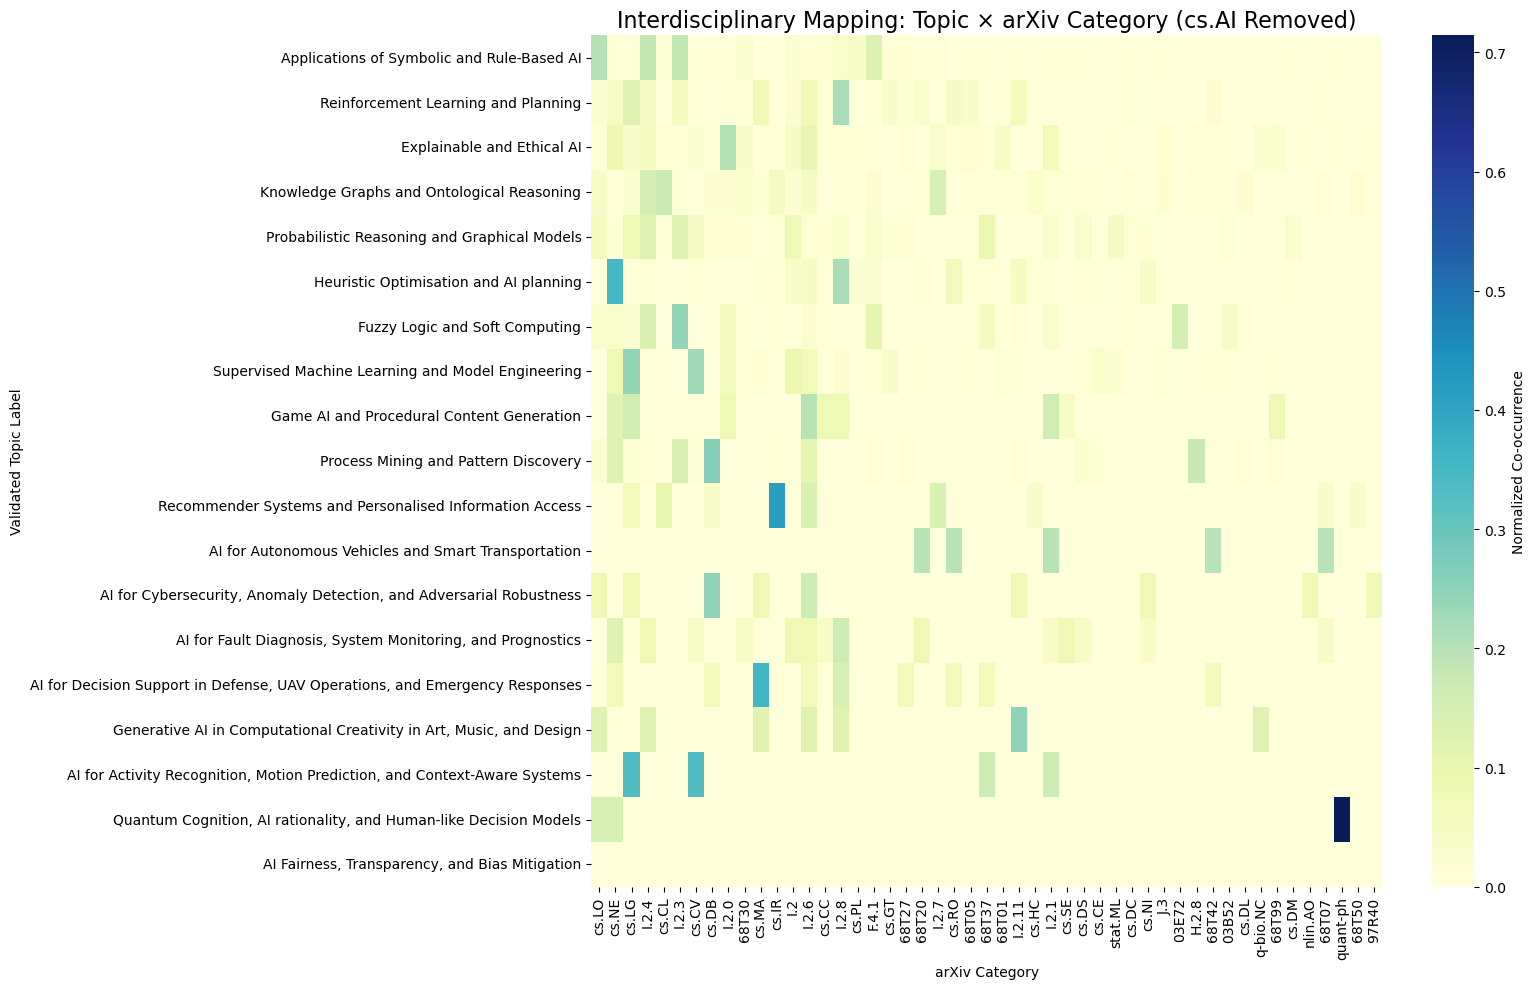

In [174]:
# Reorder the columns in the normalized matrix based on the top 50 category code order
ordered_category_codes = [code for code in top_50_df["code"] if code in normalized_matrix_no_csai.columns]
normalized_matrix_no_csai = normalized_matrix_no_csai[ordered_category_codes]

# Re-plot the heatmap with X-axis in the desired order
plt.figure(figsize=(16, 10))
sns.heatmap(normalized_matrix_no_csai,
            cmap="YlGnBu",
            cbar_kws={'label': 'Normalized Co-occurrence'})
plt.title("Interdisciplinary Mapping: Topic × arXiv Category (cs.AI Removed)", fontsize=16)
plt.xlabel("arXiv Category")
plt.ylabel("Validated Topic Label")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

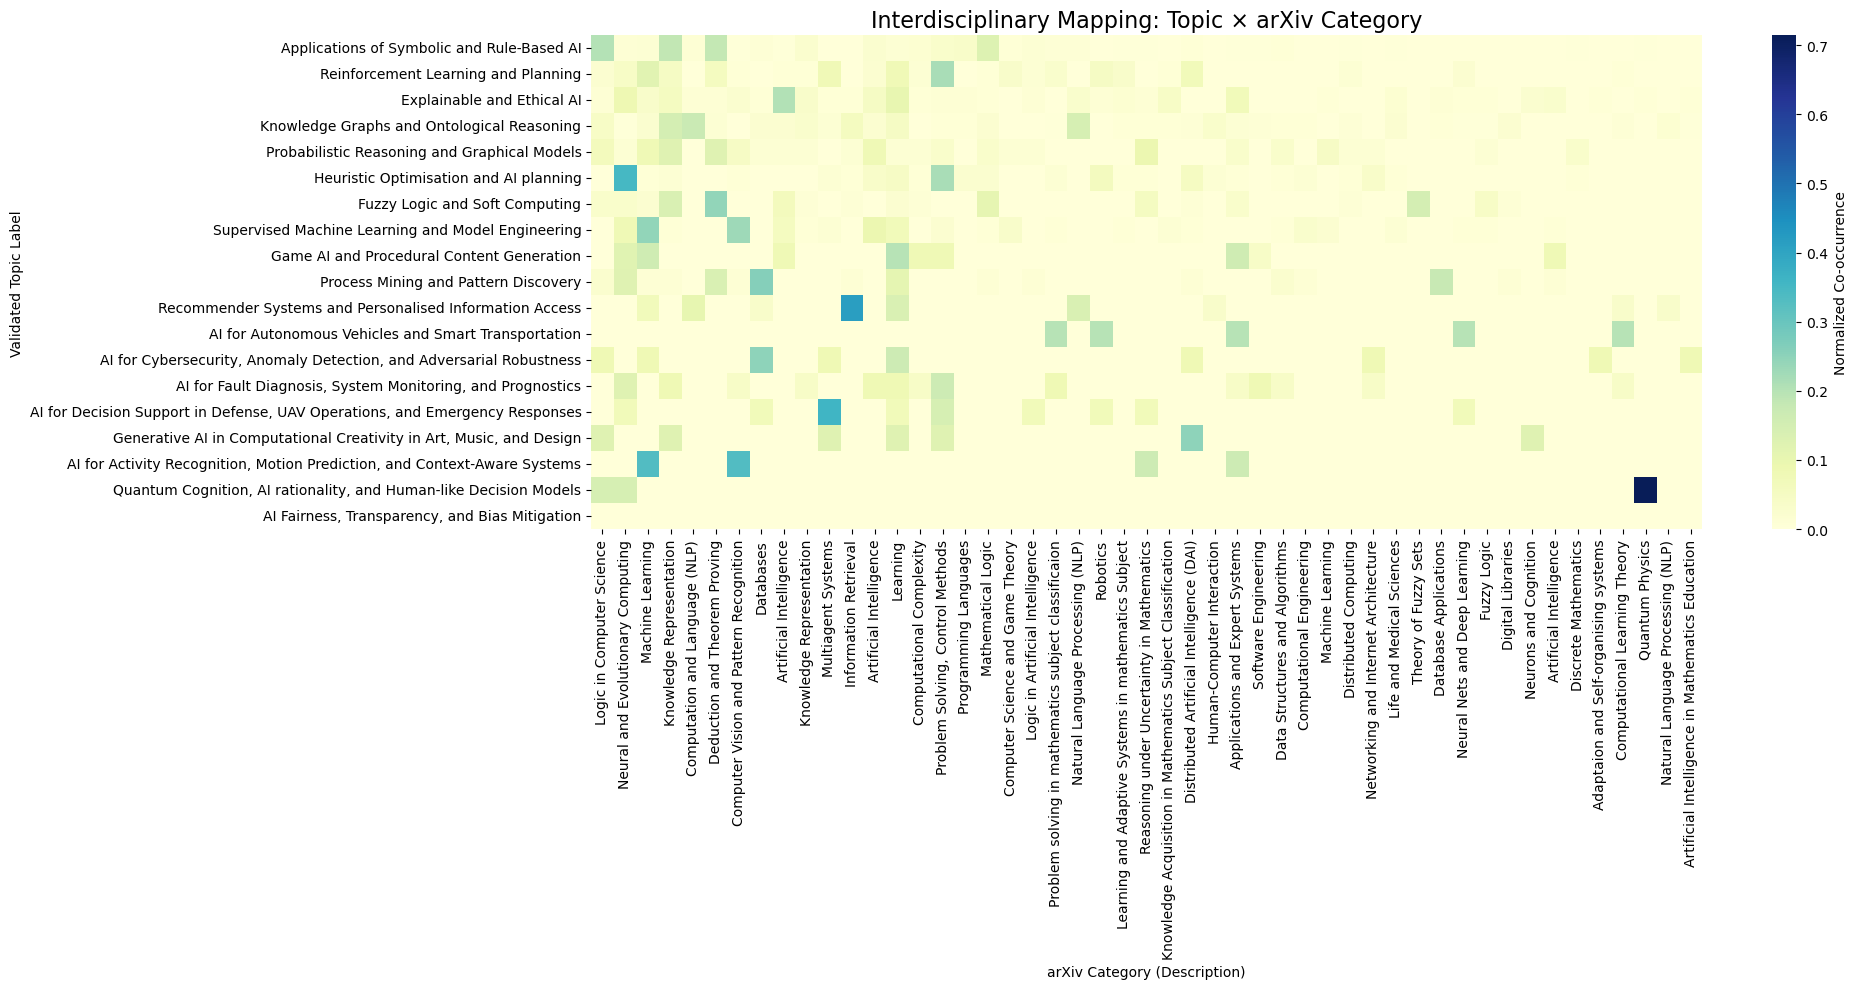

In [176]:
# Step 1: Clean up code column and ensure consistency
top_50_df["code"] = top_50_df["code"].str.strip()
top_50_df["description"] = top_50_df["description"].astype(str).str.strip()

# Step 2: Reorder the columns in the matrix based on top 50 code order
ordered_category_codes = [code for code in top_50_df["code"] if code in normalized_matrix_no_csai.columns]
normalized_matrix_ordered = normalized_matrix_no_csai[ordered_category_codes]

# Step 3: Map category code to description for X-axis labels
category_label_map = {
    row["code"]: row["description"]
    for _, row in top_50_df.iterrows()
    if row["code"] in normalized_matrix_ordered.columns
}

# Step 4: Rename columns with descriptions
normalized_matrix_ordered.columns = [category_label_map.get(col, col) for col in normalized_matrix_ordered.columns]

# Step 5: Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(normalized_matrix_ordered,
            cmap="YlGnBu",
            cbar_kws={'label': 'Normalized Co-occurrence'})
plt.title("Interdisciplinary Mapping: Topic × arXiv Category", fontsize=16)
plt.xlabel("arXiv Category (Description)")
plt.ylabel("Validated Topic Label")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

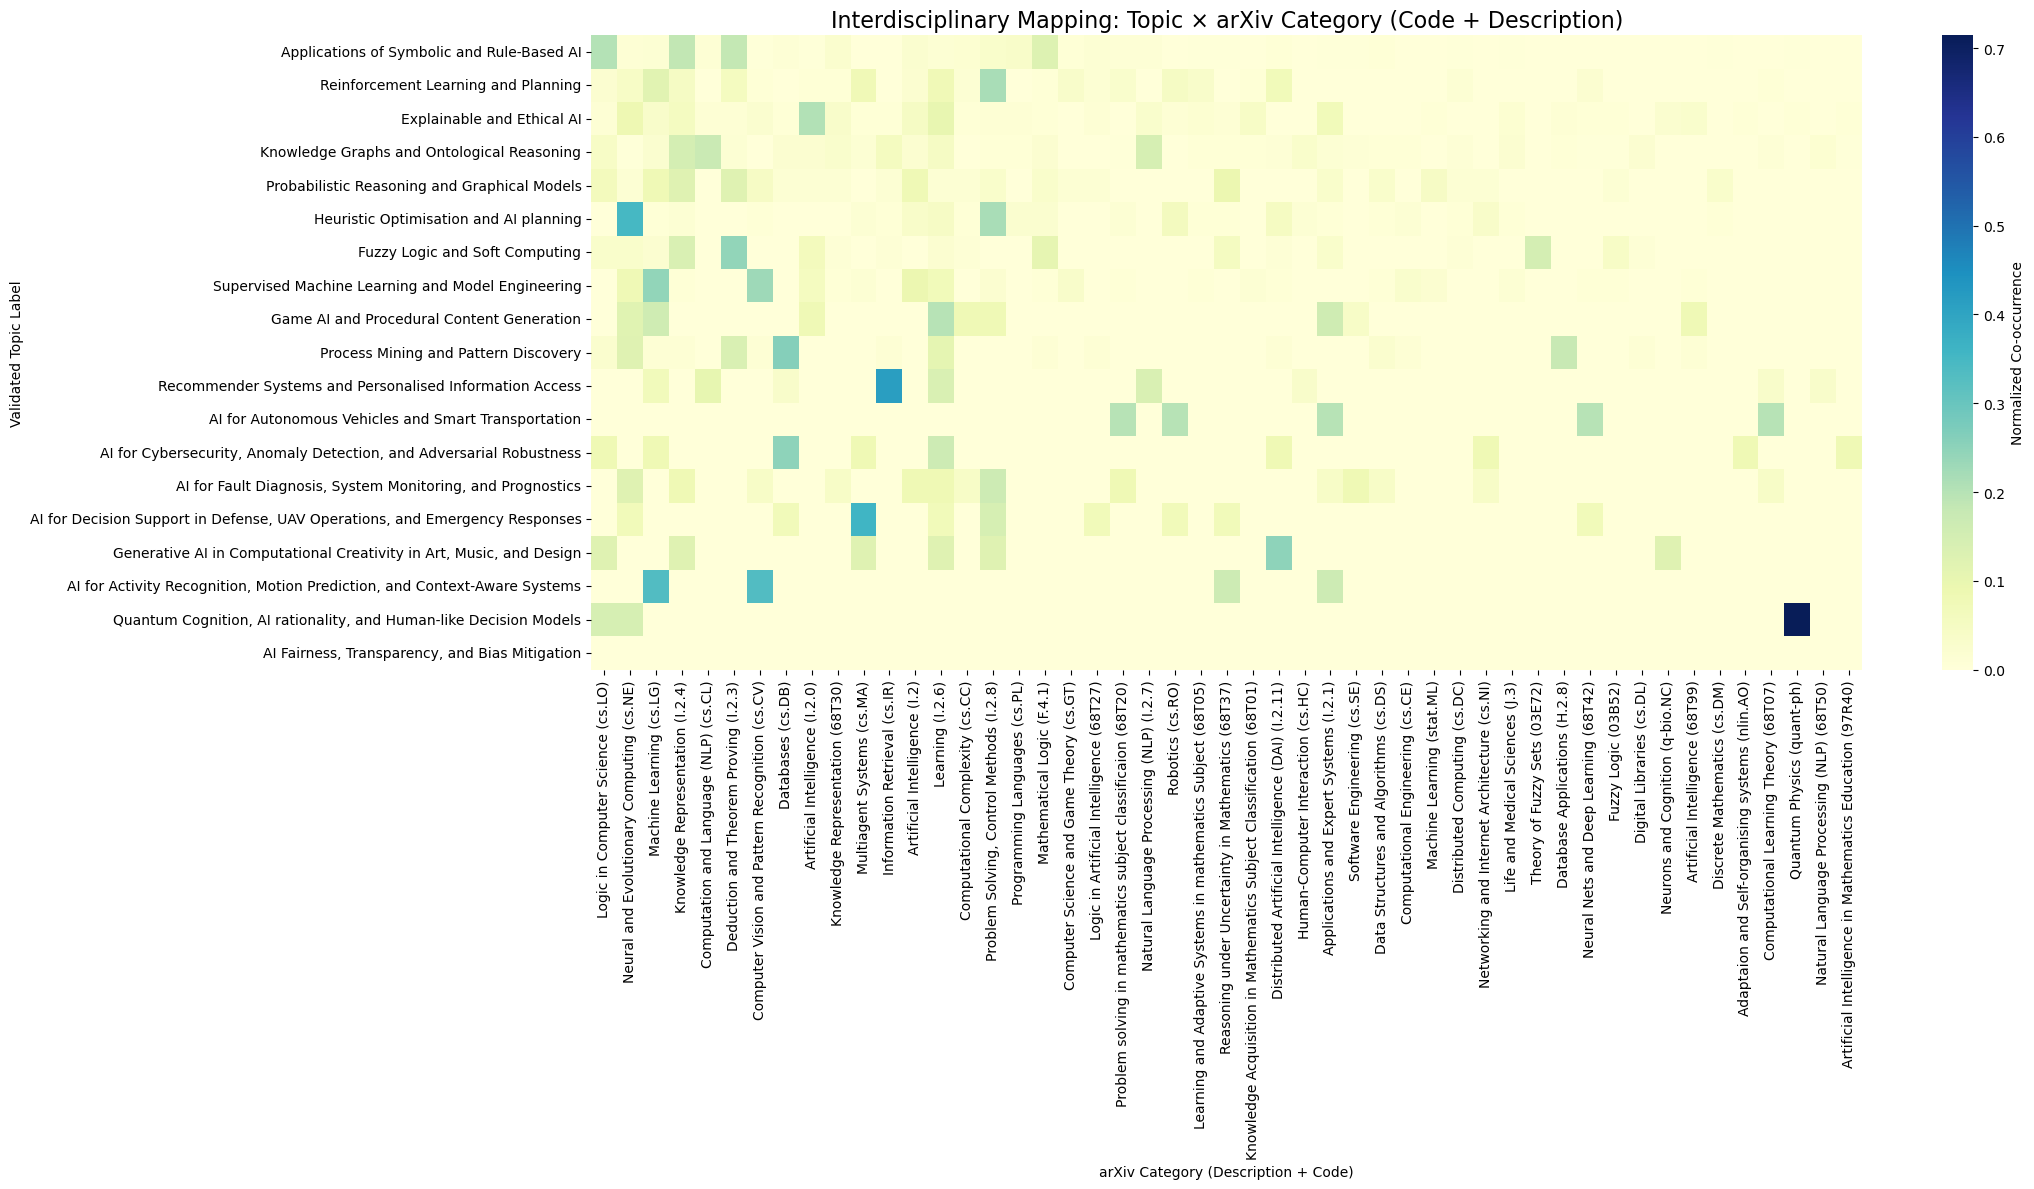

In [178]:
# Step 1: Clean up code and description columns
top_50_df["code"] = top_50_df["code"].str.strip()
top_50_df["description"] = top_50_df["description"].astype(str).str.strip()

# Step 2: Reorder columns in the matrix based on Top 50 category code order
ordered_category_codes = [code for code in top_50_df["code"] if code in normalized_matrix_no_csai.columns]
normalized_matrix_ordered = normalized_matrix_no_csai[ordered_category_codes]

# Step 3: Build label map: "Description (code)"
category_label_map = {
    row["code"]: f"{row['description']} ({row['code']})"
    for _, row in top_50_df.iterrows()
    if row["code"] in normalized_matrix_ordered.columns
}

# Step 4: Rename columns with mapped labels
normalized_matrix_ordered.columns = [category_label_map.get(col, col) for col in normalized_matrix_ordered.columns]

# Step 5: Plot the heatmap
plt.figure(figsize=(22, 12))
sns.heatmap(normalized_matrix_ordered,
            cmap="YlGnBu",
            cbar_kws={'label': 'Normalized Co-occurrence'})
plt.title("Interdisciplinary Mapping: Topic × arXiv Category (Code + Description)", fontsize=16)
plt.xlabel("arXiv Category (Description + Code)")
plt.ylabel("Validated Topic Label")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [180]:
# Import missing function
from scipy.stats import entropy

# Recompute metrics
entropy_scores = normalized_matrix_df.apply(entropy, axis=1)
top1_share = normalized_matrix_df.apply(lambda row: row.sort_values(ascending=False).iloc[0], axis=1)
top3_share = normalized_matrix_df.apply(lambda row: row.sort_values(ascending=False).iloc[:3].sum(), axis=1)

# Combine into summary DataFrame
interdisciplinarity_summary = pd.DataFrame({
    "validated_topic": normalized_matrix_df.index,
    "entropy": entropy_scores,
    "top1_share": top1_share,
    "top3_share": top3_share
}).sort_values(by="entropy", ascending=False).reset_index(drop=True)

interdisciplinarity_summary.head(20)

,validated_topic,entropy,top1_share,top3_share
0,Explainable and Ethical AI,2.987815,0.204819,0.391566
1,Knowledge Graphs and Ontological Reasoning,2.921662,0.172535,0.464789
2,Probabilistic Reasoning and Graphical Models,2.921628,0.125000,0.343750
3,Reinforcement Learning and Planning,2.720099,0.216783,0.412587
4,"AI for Fault Diagnosis, System Monitoring, and...",2.520867,0.166667,0.375000
5,Applications of Symbolic and Rule-Based AI,2.487683,0.203554,0.571890
6,Fuzzy Logic and Soft Computing,2.389716,0.244681,0.531915
7,Supervised Machine Learning and Model Engineering,2.383932,0.244604,0.568345
8,Heuristic Optimisation and AI planning,2.291620,0.350746,0.626866
9,Process Mining and Pattern Discovery,2.215149,0.260274,0.575342


/var/folders/zl/q3jfwlms76dfjrk9dywsgcmm0000gn/T/ipykernel_61807/272402986.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=interdisciplinarity_summary,


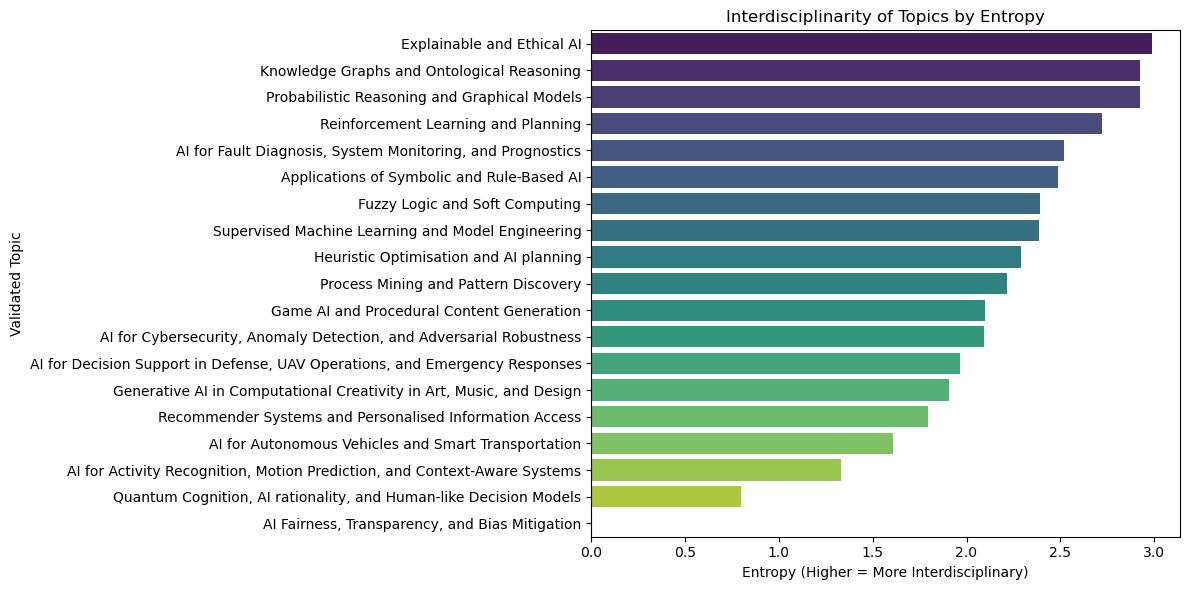

In [182]:
plt.figure(figsize=(12, 6))
sns.barplot(data=interdisciplinarity_summary,
            x="entropy", y="validated_topic", palette="viridis")
plt.xlabel("Entropy (Higher = More Interdisciplinary)")
plt.ylabel("Validated Topic")
plt.title("Interdisciplinarity of Topics by Entropy")
plt.tight_layout()
plt.show()

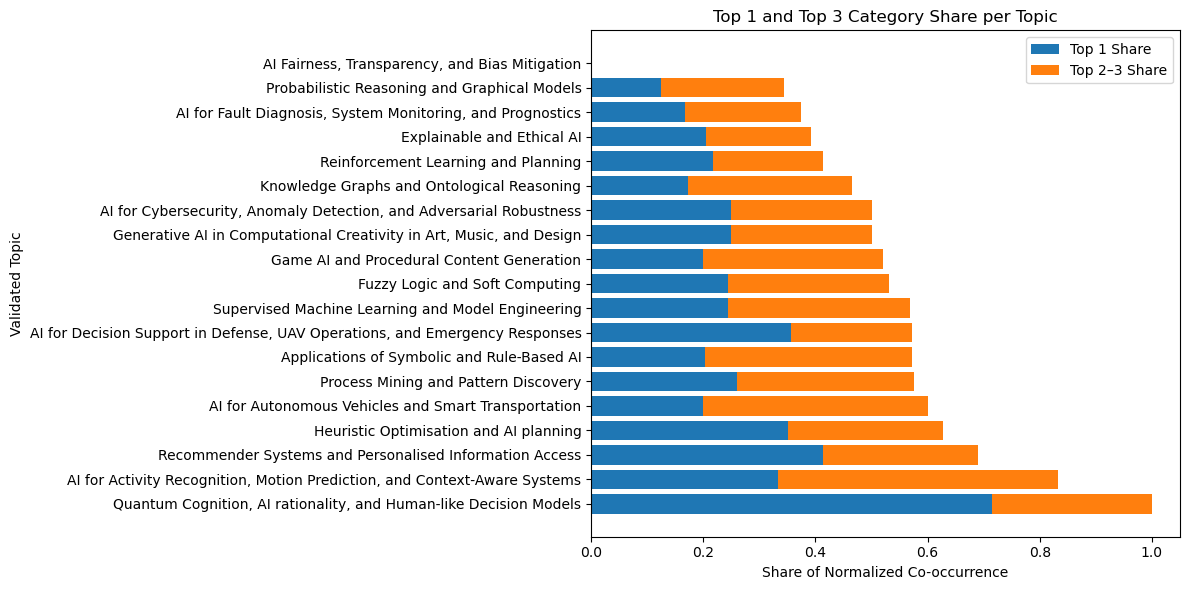

In [184]:
plt.figure(figsize=(12, 6))
interdisciplinarity_summary_sorted = interdisciplinarity_summary.sort_values(by="top3_share", ascending=False)

# Plot both top1 and remainder of top3
plt.barh(interdisciplinarity_summary_sorted["validated_topic"],
         interdisciplinarity_summary_sorted["top1_share"], label="Top 1 Share")

plt.barh(interdisciplinarity_summary_sorted["validated_topic"],
         interdisciplinarity_summary_sorted["top3_share"] - interdisciplinarity_summary_sorted["top1_share"],
         left=interdisciplinarity_summary_sorted["top1_share"], label="Top 2–3 Share")

plt.xlabel("Share of Normalized Co-occurrence")
plt.ylabel("Validated Topic")
plt.title("Top 1 and Top 3 Category Share per Topic")
plt.legend()
plt.tight_layout()
plt.show()